# Aaron Szabo Final Project

**Course**: CMSC 389A Practical Deep Learning  

**Imports**  

In [77]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
from keras.layers import Dense
from keras.models import Sequential
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
import numpy as np
import pandas as pd

from keras.layers import Dense
from keras.models import Sequential

## Load Data

In [4]:
file_name_white = 'winequality-white.csv'
file_name_red = 'winequality-red.csv'
columns = [
    'Fixed acidity',
    'Volatile acidity',
    'Citric acid',
    'Residual sugar',
    'Chlorides',
    'Free sulfur dioxide',
    'Total sulfur dioxide',
    'Density',
    'pH',
    'Sulphates',
    'Alcohol',
    'Quality'
]

df_white = pd.read_csv(file_name_white, names=columns, delimiter=';', header=0)
df_red = pd.read_csv(file_name_red, names=columns, delimiter=';', header=0)
df_white[columns[:-1]] = df_white[columns[:-1]].astype(float)
df_red[columns[:-1]] = df_red[columns[:-1]].astype(float)
df_white[columns[-1]] = df_white[columns[-1]].astype(str)
df_red[columns[-1]] = df_red[columns[-1]].astype(str)

Normalizing 

In [5]:
# Normalize all the values between -0.5 and 0.5
for feature in df_white.columns[:-1]:
    max_value = df_white[feature].max()
    min_value = df_white[feature].min()
    mean_value = df_white[feature].mean()
    df_white[feature] = (df_white[feature] - mean_value) / (max_value - min_value)
for feature in df_red.columns[:-1]:
    max_value = df_red[feature].max()
    min_value = df_red[feature].min()
    mean_value = df_red[feature].mean()
    df_red[feature] = (df_red[feature] - mean_value) / (max_value - min_value)

Lets now examine the data after normalizing it.

In [6]:
df_red.head()

,Fixed acidity,Volatile acidity,Citric acid,Residual sugar,Chlorides,Free sulfur dioxide,Total sulfur dioxide,Density,pH,Sulphates,Alcohol,Quality
0,-0.081384,0.117931,-0.270976,-0.043754,-0.019143,-0.068661,-0.044056,0.077336,0.156604,-0.058772,-0.157382,5
1,-0.045986,0.241219,-0.270976,0.004191,0.017585,0.128522,0.072552,0.003915,-0.087491,0.013085,-0.095844,5
2,-0.045986,0.159027,-0.230976,-0.016357,0.007568,-0.012323,0.026616,0.018599,-0.040247,-0.004880,-0.095844,5
3,0.254899,-0.169740,0.289024,-0.043754,-0.020812,0.015846,0.047817,0.092021,-0.118987,-0.046796,-0.095844,6
4,-0.081384,0.117931,-0.270976,-0.043754,-0.019143,-0.068661,-0.044056,0.077336,0.156604,-0.058772,-0.157382,5


## Load the examples into a data variable

In [7]:
class Example:
    """
    Class to represent a data example.
    """

    def __init__(self, features, label):
        """
        Create a new example.

        :param label: The label (0 / 1) of the example
        :param vocab: The real valued features of patient (list)
        """
        self.features = features
        self.label = label

In [9]:
data_white = []
for row in df_white.itertuples():
    label = row[-1]
    features = row[1:-1]
    example = Example(features, label)
    data_white.append(example)
data_red = []
for row in df_red.itertuples():
    label = row[-1]
    features = row[1:-1]
    example = Example(features, label)
    data_red.append(example)

In [10]:
#data = shuffle(data, random_state=kSEED)

X_W = [example.features for example in data_white]
y_W = [example.label for example in data_white]
X_R = [example.features for example in data_red]
y_R = [example.label for example in data_red]

## Encoding the Labels

Before, our output variable only contained a binary label (either a 1 or a 0) that we wanted to predict. In this case, we have 3 potential output classes represented as strings. A common practice to use in this scenario is to create a one hot encoding for each class. A one-hot encoding is a matrix where each class is assigned an index and if the value at the index is True (>1), the data point belongs to that class. For example lets say our encoding looks like the following:

Iris Setosa (index 0), Iris Versicolor (index 1), Iris Virginica (index 2)  
If flower is Iris Setosa: `[1,0,0]`  
If flower is Iris Versicolor: `[0,1,0]`  
If flower is Iris Virginica: `[0,0,1]`  

This is nice because our network can simply output a 1x3 vector (3 output nodes) where it contains the probability of being that class at each index. We can then just take the class with the highest probability and that is our class.

Encoding the classes is really easy to do if you take advantage of sklearn's `Label Encoder`.

In [24]:
#3 is the lowest quality
s1 = np.array([0,0,0,0,0,0,0])
s2 = np.array([0,0,0,0,0,0,0])
for val in y_W:
    val_int = int(val)
    s1[val_int-3] += 1
for val in y_R:
    val_int = int(val)
    s2[val_int-3] += 1
print(s1)
print(s2)

[  20  163 1457 2198  880  175    5]
[ 10  53 681 638 199  18   0]


In [28]:
print(len(y_W))

4898


In [40]:
#encoder =  LabelEncoder()
#encoded_y_W = encoder.fit_transform(y_W)
#encoded_y_R = encoder.fit_transform(y_R)
#dummy_y_W = pd.get_dummies(encoded_y_W).values
#dummy_y_R = pd.get_dummies(encoded_y_R).values

dummy_y_W = np.zeros((len(y_W),7), np.int32)
dummy_y_R = np.zeros((len(y_R),7), np.int32)
for i in range(len(y_W)):
    val_int = int(y_W[i])
    val_int -= 3
    dummy_y_W[i,val_int] = 1
for i in range(len(y_R)):
    val_int = int(y_R[i])
    val_int -= 3
    dummy_y_R[i,val_int] = 1

Lets take a look at the encoded values for the fist 5 rows.

In [41]:
for i in range(5):
    print('{:} -> {:}'.format(y_W[i], dummy_y_W[i]))
for i in range(5):
    print('{:} -> {:}'.format(y_R[i], dummy_y_R[i]))

6 -> [0 0 0 1 0 0 0]
6 -> [0 0 0 1 0 0 0]
6 -> [0 0 0 1 0 0 0]
6 -> [0 0 0 1 0 0 0]
6 -> [0 0 0 1 0 0 0]
5 -> [0 0 1 0 0 0 0]
5 -> [0 0 1 0 0 0 0]
5 -> [0 0 1 0 0 0 0]
6 -> [0 0 0 1 0 0 0]
5 -> [0 0 1 0 0 0 0]


## Train-test Split

We will take a random 80% for training examples and a random 20% for testing. We can do this quickly using sklearn's train test split function.
 
Note how we use `dummy_y` instead of `y` as it contains our encoded vector.

In [60]:
X_train_W, X_test_W, y_train_W, y_test_W = train_test_split(X_W,dummy_y_W,test_size=0.2, random_state=10)
X_train_R, X_test_R, y_train_R, y_test_R = train_test_split(X_R,dummy_y_R,test_size=0.2, random_state=10)

X_train_W = np.array(X_train_W)
y_train_W = np.array(y_train_W)
X_test_W = np.array(X_test_W)
y_test_W = np.array(y_test_W)

print('Total White Examples: {:}\nTrain Examples: {:}\nTest Examples: {:4d}'.format(len(data_white), len(X_train_W), len(X_test_W)))
print('Total Red Examples: {:}\nTrain Examples: {:}\nTest Examples: {:4d}'.format(len(data_red), len(X_train_R), len(X_test_R)))

Total White Examples: 4898
Train Examples: 3918
Test Examples:  980
Total Red Examples: 1599
Train Examples: 1279
Test Examples:  320


## Implementing the Model

Notice how our model architecture looks extremely similar to the one we used for the binary classification task on the Diabetes dataset. The only big difference here is in the last line of the model where our final dense layer contains 3 neurons rather than 1. This is because each neuron will correspond to each of the Iris classes and contain a probability for each class.

For example if the model output was `[0.8, 0.1, 0.1]`, then the predicted class is Iris Setosa.

In [139]:
model = Sequential()
model.add(Dense(11,input_shape=(11,),activation='sigmoid'))
model.add(Dense(30,activation='sigmoid'))
#model.add(Dense(40,activation='sigmoid'))
#model.add(Dense(50,activation='sigmoid'))
#model.add(Dense(40,activation='sigmoid'))
model.add(Dense(30,activation='relu'))
model.add(Dense(11,activation='relu'))
model.add(Dense(7,activation='softmax'))

### Compiling the Model

Before we used the `binary_crossentropy` loss in the Diabetes dataset. We will now use the `category_crossentropy` loss to handle more than two classes. Check out the link [here](http://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) for more information on the differences between the two but just remember that binary is for two classes and categorical is for more than two.

In [140]:
#def cus_metric(y_true, y_pred):
#    diff = np.nonzero(y_true.eval())-np.nonzero(y_pred.eval())
#    return diff^2


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Model Summary

To get a quick overview of our model, we can use the `.summary()` property of Keras.

In [141]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 11)                132       
_________________________________________________________________
dense_77 (Dense)             (None, 30)                360       
_________________________________________________________________
dense_78 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_79 (Dense)             (None, 11)                341       
_________________________________________________________________
dense_80 (Dense)             (None, 7)                 84        
Total params: 1,847
Trainable params: 1,847
Non-trainable params: 0
_________________________________________________________________


### Training the Model

We will train then neural network on the data we setup before. We will train for 100 epochs with a batch size of 10.

In [142]:
model.fit(X_train_W, y_train_W, epochs=500, batch_size=10)

Epoch 1/500
3918/3918 [==============================] - 1s 270us/step - loss: 1.3606 - acc: 0.4288
Epoch 2/500
3918/3918 [==============================] - 0s 110us/step - loss: 1.2975 - acc: 0.4461
Epoch 3/500
3918/3918 [==============================] - 0s 108us/step - loss: 1.2939 - acc: 0.4461
Epoch 4/500
3918/3918 [==============================] - 0s 109us/step - loss: 1.2884 - acc: 0.4464
Epoch 5/500
3918/3918 [==============================] - 0s 105us/step - loss: 1.2618 - acc: 0.4556
Epoch 6/500
3918/3918 [==============================] - 0s 102us/step - loss: 1.2187 - acc: 0.4788
Epoch 7/500
3918/3918 [==============================] - 0s 104us/step - loss: 1.1961 - acc: 0.4890
Epoch 8/500
3918/3918 [==============================] - 0s 107us/step - loss: 1.1837 - acc: 0.4992
Epoch 9/500
3918/3918 [==============================] - 0s 105us/step - loss: 1.1737 - acc: 0.5026
Epoch 10/500
3918/3918 [==============================] - 0s 105us/step - loss: 1.1638 - acc: 0.5079

3918/3918 [==============================] - 0s 99us/step - loss: 1.0987 - acc: 0.5391: 0s - loss: 1.0997 - acc: 
Epoch 82/500
3918/3918 [==============================] - 0s 99us/step - loss: 1.0974 - acc: 0.5416
Epoch 83/500
3918/3918 [==============================] - 0s 99us/step - loss: 1.0971 - acc: 0.5327
Epoch 84/500
3918/3918 [==============================] - 0s 99us/step - loss: 1.0972 - acc: 0.5380
Epoch 85/500
3918/3918 [==============================] - 0s 104us/step - loss: 1.0973 - acc: 0.5360
Epoch 86/500
3918/3918 [==============================] - 0s 98us/step - loss: 1.0985 - acc: 0.5316
Epoch 87/500
3918/3918 [==============================] - 0s 96us/step - loss: 1.0950 - acc: 0.5347
Epoch 88/500
3918/3918 [==============================] - 0s 99us/step - loss: 1.0970 - acc: 0.5373
Epoch 89/500
3918/3918 [==============================] - 0s 98us/step - loss: 1.0944 - acc: 0.5373
Epoch 90/500
3918/3918 [==============================] - 0s 98us/step - loss: 1.0973

3918/3918 [==============================] - 0s 102us/step - loss: 1.0753 - acc: 0.5485
Epoch 162/500
3918/3918 [==============================] - 0s 98us/step - loss: 1.0771 - acc: 0.5508
Epoch 163/500
3918/3918 [==============================] - 0s 107us/step - loss: 1.0759 - acc: 0.5457
Epoch 164/500
3918/3918 [==============================] - 0s 102us/step - loss: 1.0743 - acc: 0.5475
Epoch 165/500
3918/3918 [==============================] - 0s 105us/step - loss: 1.0747 - acc: 0.5490
Epoch 166/500
3918/3918 [==============================] - 0s 117us/step - loss: 1.0756 - acc: 0.5516
Epoch 167/500
3918/3918 [==============================] - 0s 103us/step - loss: 1.0743 - acc: 0.5510
Epoch 168/500
3918/3918 [==============================] - 0s 100us/step - loss: 1.0725 - acc: 0.5462
Epoch 169/500
3918/3918 [==============================] - 0s 102us/step - loss: 1.0719 - acc: 0.5518
Epoch 170/500
3918/3918 [==============================] - 0s 101us/step - loss: 1.0730 - acc: 0.

3918/3918 [==============================] - 0s 101us/step - loss: 1.0555 - acc: 0.5579
Epoch 242/500
3918/3918 [==============================] - 0s 101us/step - loss: 1.0562 - acc: 0.5577
Epoch 243/500
3918/3918 [==============================] - 0s 100us/step - loss: 1.0567 - acc: 0.5536
Epoch 244/500
3918/3918 [==============================] - 0s 102us/step - loss: 1.0547 - acc: 0.5503
Epoch 245/500
3918/3918 [==============================] - 0s 102us/step - loss: 1.0546 - acc: 0.5592
Epoch 246/500
3918/3918 [==============================] - 0s 100us/step - loss: 1.0549 - acc: 0.5516
Epoch 247/500
3918/3918 [==============================] - 0s 99us/step - loss: 1.0548 - acc: 0.5546
Epoch 248/500
3918/3918 [==============================] - 0s 99us/step - loss: 1.0536 - acc: 0.5579
Epoch 249/500
3918/3918 [==============================] - 0s 101us/step - loss: 1.0541 - acc: 0.5559
Epoch 250/500
3918/3918 [==============================] - 0s 101us/step - loss: 1.0549 - acc: 0.5

3918/3918 [==============================] - 0s 102us/step - loss: 1.0299 - acc: 0.5610
Epoch 322/500
3918/3918 [==============================] - 0s 101us/step - loss: 1.0285 - acc: 0.5722
Epoch 323/500
3918/3918 [==============================] - 0s 102us/step - loss: 1.0288 - acc: 0.5712
Epoch 324/500
3918/3918 [==============================] - 0s 102us/step - loss: 1.0297 - acc: 0.5628
Epoch 325/500
3918/3918 [==============================] - 0s 101us/step - loss: 1.0282 - acc: 0.5684
Epoch 326/500
3918/3918 [==============================] - 0s 102us/step - loss: 1.0290 - acc: 0.5658
Epoch 327/500
3918/3918 [==============================] - 0s 114us/step - loss: 1.0299 - acc: 0.5730
Epoch 328/500
3918/3918 [==============================] - 0s 115us/step - loss: 1.0299 - acc: 0.5674
Epoch 329/500
3918/3918 [==============================] - 0s 110us/step - loss: 1.0278 - acc: 0.5699
Epoch 330/500
3918/3918 [==============================] - 0s 111us/step - loss: 1.0268 - acc: 0

3918/3918 [==============================] - 0s 110us/step - loss: 1.0114 - acc: 0.5763
Epoch 402/500
3918/3918 [==============================] - 0s 108us/step - loss: 1.0109 - acc: 0.5717
Epoch 403/500
3918/3918 [==============================] - 0s 107us/step - loss: 1.0109 - acc: 0.5750
Epoch 404/500
3918/3918 [==============================] - 0s 105us/step - loss: 1.0118 - acc: 0.5710
Epoch 405/500
3918/3918 [==============================] - 0s 105us/step - loss: 1.0095 - acc: 0.5771
Epoch 406/500
3918/3918 [==============================] - 0s 106us/step - loss: 1.0093 - acc: 0.5738
Epoch 407/500
3918/3918 [==============================] - 0s 103us/step - loss: 1.0125 - acc: 0.5753
Epoch 408/500
3918/3918 [==============================] - 0s 108us/step - loss: 1.0092 - acc: 0.5694
Epoch 409/500
3918/3918 [==============================] - 0s 105us/step - loss: 1.0075 - acc: 0.5727
Epoch 410/500
3918/3918 [==============================] - 0s 103us/step - loss: 1.0108 - acc: 0

3918/3918 [==============================] - 0s 100us/step - loss: 0.9996 - acc: 0.5809
Epoch 482/500
3918/3918 [==============================] - 0s 103us/step - loss: 0.9993 - acc: 0.5758
Epoch 483/500
3918/3918 [==============================] - 0s 102us/step - loss: 1.0017 - acc: 0.5799
Epoch 484/500
3918/3918 [==============================] - 0s 102us/step - loss: 1.0003 - acc: 0.5740
Epoch 485/500
3918/3918 [==============================] - 0s 101us/step - loss: 1.0013 - acc: 0.5807
Epoch 486/500
3918/3918 [==============================] - 0s 101us/step - loss: 1.0020 - acc: 0.5791
Epoch 487/500
3918/3918 [==============================] - 0s 101us/step - loss: 1.0002 - acc: 0.5771
Epoch 488/500
3918/3918 [==============================] - 0s 102us/step - loss: 1.0002 - acc: 0.5801
Epoch 489/500
3918/3918 [==============================] - 0s 99us/step - loss: 1.0000 - acc: 0.5781
Epoch 490/500
3918/3918 [==============================] - 0s 100us/step - loss: 1.0010 - acc: 0.

### Evaluating the Model

We can now run the model on our test data and check the accuracy of the model. Since our `y_test` will be a matrix with a 1 at an element and our predicted output will also be a matrix but with probabilities at each index, we can check if we got the right class by selecting the index with the highest value. In the case of `y_test`, it will always be the correct class and in the case of our prediction, it will be the class we are most confident it is as the probabilities in the output vector sum up to 1.

In [143]:
y_pred_W = model.predict(X_test_W)
y_test_class_W = np.argmax(y_test_W,axis=1)
y_pred_class_W = np.argmax(y_pred_W,axis=1)

accuracy = accuracy_score(y_test_class_W, y_pred_class_W)
print(accuracy)

0.5408163265306123


### Results

As you can see, we achieve an incredible accuracy of 96.7% on the prediction task. This was also trained super quickly and with a minimal amount of code. We can see the power of neural networks for classification.

## Analysis Report

Here are the scorse computed based on what we talked about in class.  

In [50]:
print(classification_report(y_test_class,y_pred_class))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         6
          1       1.00      0.91      0.95        11
          2       0.93      1.00      0.96        13

avg / total       0.97      0.97      0.97        30



A visualization of the confusion matrix for our model. The confusion matrix helps us learn what the model predicted in comparison to the ground truth class. This allows us to identify where the model goes wrong in general. You can learn more about confusion matrices [here](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/).

In [55]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


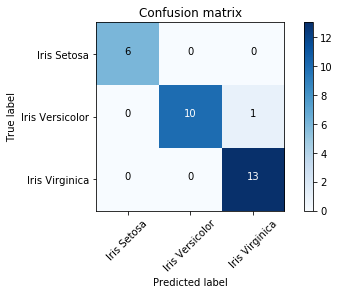

In [56]:
cnf_matrix = confusion_matrix(y_test_class,y_pred_class)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Iris Setosa', 'Iris Versicolor', 'Iris Virginica'], title='Confusion matrix')